# Fuzzy Inference System

## Takagi-Sugeno (TS) Fuzzy Model
We use a Takagi-Sugeno (TS) Fuzzy Model since we want an output probability that the patient has alzheimers, rather than a fuzzy set output as with the Mamdani model. Since the output is binary (AD vs Non-AD) we use zero-order TS.

## Preparing Fuzzy Sets

### Imports

In [401]:
from pathlib import Path
import pandas as pd
import numpy as np
from simpful import *
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, fbeta_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from itertools import product, combinations

### Load Data

In [402]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected_fis.csv")
X_test = pd.read_csv(path / "X_test_selected_fis.csv")
y_train = pd.read_csv(path / "y_train.csv")
y_test = pd.read_csv(path / "y_test.csv")

# Drop the unwanted index-like column
if "Unnamed: 0" in X_train.columns:
    X_train = X_train.drop(columns=["Unnamed: 0"])
if "Unnamed: 0" in X_test.columns:
    X_test = X_test.drop(columns=["Unnamed: 0"])
y_train = y_train["Diagnosis"]
y_test = y_test["Diagnosis"]

print(X_train.shape)
print(y_train.shape)
print(X_train.columns)

np.random.seed(42)


(1934, 16)
(1934,)
Index(['ADL', 'AlcoholConsumption', 'BehavioralProblems',
       'CardiovascularDisease', 'CholesterolHDL', 'CholesterolLDL',
       'Depression', 'Diabetes', 'Disorientation', 'EducationLevel',
       'FunctionalAssessment', 'Hypertension', 'MMSE', 'MemoryComplaints',
       'SleepQuality', 'Smoking'],
      dtype='object')


### Identify Numeric Features within Recommended Features

The further code does not use this directly, but this is for observation to then be used manually with clinical rationale.

In [403]:
# Finds all numeric features from the recommended ones (from feature engineering)
numeric_cols = [
    "Age",
    "BMI",
    "AlcoholConsumption",
    "PhysicalActivity",
    "DietQuality",
    "SleepQuality",
    "SystolicBP",
    "DiastolicBP",
    "CholesterolTotal",
    "CholesterolLDL",
    "CholesterolHDL",
    "CholesterolTriglycerides",
    "MMSE",
    "FunctionalAssessment",
    "ADL",
]

common = [col for col in X_train.columns if col in numeric_cols]

print(common)

['ADL', 'AlcoholConsumption', 'CholesterolHDL', 'CholesterolLDL', 'FunctionalAssessment', 'MMSE', 'SleepQuality']


### Preliminary Feature Selection - Model Suitability Clinical Rationale

The features used for this model are selected based on the following: from the features identified during the feature engineering, only the numerical ones are considered since the categorical features have too few classes to create meaningful fuzzy sets. Of these 7 numerical features, we selct 5 which provide both cognitive/functional and vascular/metabolic context:
- MMSE (Mini-Mental State Examination) - Standard global cognitive screening test used in dementia and Alzheimer’s diagnosis and staging
- FunctionalAssessment - Functional decline (managing finances, medication, daily tasks) is core to dementia diagnosis and staging, not just a side measure
- ADL (Activities of Daily Living) - ADL scores (bathing, dressing, feeding, toileting, etc.) are a classic way to measure the impact of dementia on basic autonomy
- Sleep quality - Not a diagnostic marker, but a useful risk-related feature
- CholesterolHDL - Vascular risk factors (lipids, hypertension, diabetes) are important for vascular dementia and mixed dementia, and they also interact with Alzheimer’s pathology


<!-- - SystolicBP - Hypertension (especially midlife) is a key risk factor for later-life cognitive impairment and dementia -->

#### Prepare dataframe and input and output columns

In [404]:
# Possible features to use based on model suitability and clinical rationale
candidate_features = [
    "MMSE",
    "FunctionalAssessment",
    "ADL",
    "SleepQuality",
    "CholesterolHDL",
]

# Extract only candidate features
X_train_candidates = X_train[candidate_features].copy()
y_train_candidates = y_train.copy()
print(X_train_candidates.head(5))


# Validation split
X_train_cand_inner, X_val_cand, y_train_cand_inner, y_val_cand = train_test_split(
    X_train_candidates,
    y_train_candidates,
    test_size=0.2,
    stratify=y_train_candidates,
    random_state=42,
)


        MMSE  FunctionalAssessment       ADL  SleepQuality  CholesterolHDL
0  12.292725              6.751583  9.061350      8.389189       50.421329
1   3.731915              8.136757  5.886320      6.155182       51.891374
2  26.980845              4.803596  0.123688      6.249780       36.567192
3   2.313023              2.952020  9.017740      6.978128       58.584837
4  19.739526              6.931809  1.927703      4.866378       52.130322


### Create Fuzzy Set Membership Functions

- MMSE - https://muhc.ca/sites/default/files/micro/m-PT-OT/OT/Mini-Mental-State-Exam-%28MMSE%29.pdf
    - 24-30: No cognitive impairment 
    - 18-23: Mild cognitive impairment 
    - 0-17: Severe cognitive impairment 
- Functional Assessment - http://msdmanuals.com/professional/multimedia/table/modified-katz-activities-of-daily-living-adl-scale 
    - Scale the above from range of 0-6 to 0-10
- Activities of daily living (ADL) - http://msdmanuals.com/professional/multimedia/table/modified-katz-activities-of-daily-living-adl-scale
    - Scale the above from range of 0-6 to 0-10
- Sleep quality - https://academic.oup.com/sleep/article-abstract/36/7/1027/2453864?redirectedFrom=fulltext
    - 4-6
- Cholesteroal HDL - https://www.heartuk.org.uk/cholesterol/understanding-your-cholesterol-test-results-
    - Threshold differs for men and women:
    - above 39 for a man is healthy
    - above 46 for a woman is healthy
    - But with fuzzy sets we can blur the boundary


<!-- - Systolic BP - https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
    - \<120: Normal
    - 120-129: Elevated
    - 130-139: Stage 1 Hypertension
    - 140-180: Stage 2 Hypertension --> -->

In [405]:
FS = FuzzySystem(show_banner=False)

# Input: MMSE
MMSE_S_1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=19), term="Severe")
MMSE_S_2 = FuzzySet(function=Triangular_MF(a=16, b=20, c=25), term="Mild")
MMSE_S_3 = FuzzySet(function=Triangular_MF(a=22, b=30, c=30), term="Normal")
MMSE = LinguisticVariable([MMSE_S_1, MMSE_S_2, MMSE_S_3], universe_of_discourse=[0,30])
FS.add_linguistic_variable("MMSE", MMSE)

# Input: Functional Assessment
FUNC_S_1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=5), term="SevereImpairment")
FUNC_S_2 = FuzzySet(function=Triangular_MF(a=3, b=5, c=7), term="ModerateImpairment")
FUNC_S_3 = FuzzySet(function=Triangular_MF(a=5, b=10, c=10), term="NoImpairment")
FUNC = LinguisticVariable([FUNC_S_1, FUNC_S_2, FUNC_S_3], universe_of_discourse=[0,10])
FS.add_linguistic_variable("FunctionalAssessment", FUNC)

# Input: ADL
ADL_S_1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=5), term="VeryDependent")
ADL_S_2 = FuzzySet(function=Triangular_MF(a=3, b=5, c=7), term="ModerateImpairment")
ADL_S_3 = FuzzySet(function=Triangular_MF(a=5, b=10, c=10), term="Independent")
ADL = LinguisticVariable([ADL_S_1, ADL_S_2, ADL_S_3], universe_of_discourse=[0,10])
FS.add_linguistic_variable("ADL", ADL)

# Input: Sleep Quality
SQ_S_1 = FuzzySet(function=Triangular_MF(a=4, b=4, c=6), term="Poor")
SQ_S_2 = FuzzySet(function=Triangular_MF(a=5, b=7, c=9), term="Moderate")
SQ_S_3 = FuzzySet(function=Triangular_MF(a=7, b=10, c=10), term="Good")
SQ = LinguisticVariable([SQ_S_1, SQ_S_2, SQ_S_3], universe_of_discourse=[4,10])
FS.add_linguistic_variable("SleepQuality", SQ)

# Input: Cholesterol HDL
HDL_S_1 = FuzzySet(function=Triangular_MF(a=20, b=20, c=46), term="Low")
HDL_S_2 = FuzzySet(function=Triangular_MF(a=39, b=100, c=100), term="Normal")
HDL = LinguisticVariable([HDL_S_1, HDL_S_2], universe_of_discourse=[20,100])
FS.add_linguistic_variable("CholesterolHDL", HDL)

# # Input: Systolic BP
# SBP_S_1 = FuzzySet(function=Triangular_MF(a=90,  b=90,  c=120), term="Normal")
# SBP_S_2 = FuzzySet(function=Triangular_MF(a=115, b=125, c=135), term="Elevated")
# SBP_S_3 = FuzzySet(function=Triangular_MF(a=130, b=160, c=180), term="Hypertensive")
# SBP = LinguisticVariable([SBP_S_1, SBP_S_2, SBP_S_3], universe_of_discourse=[90,180])
# FS.add_linguistic_variable("SystolicBP", SBP)

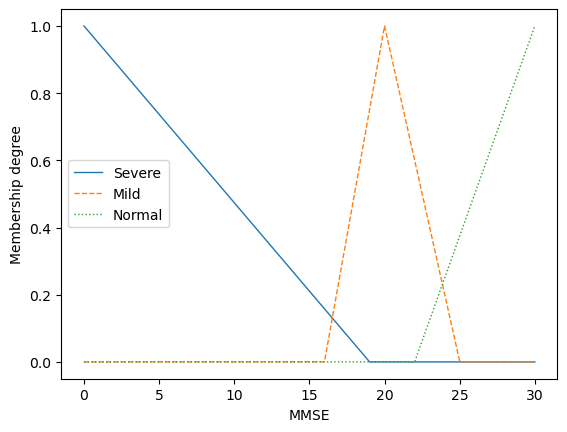

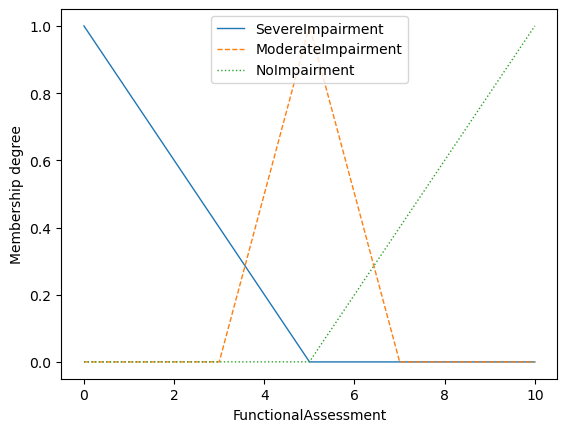

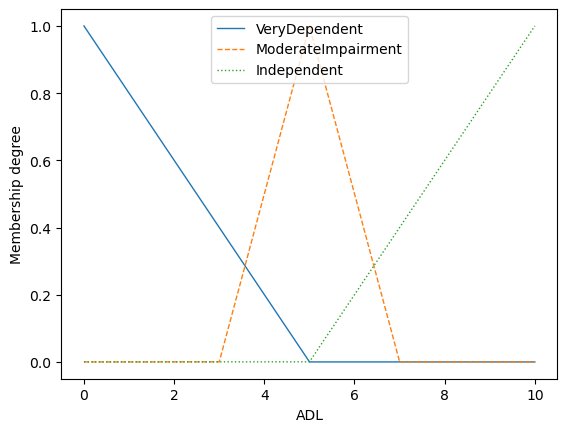

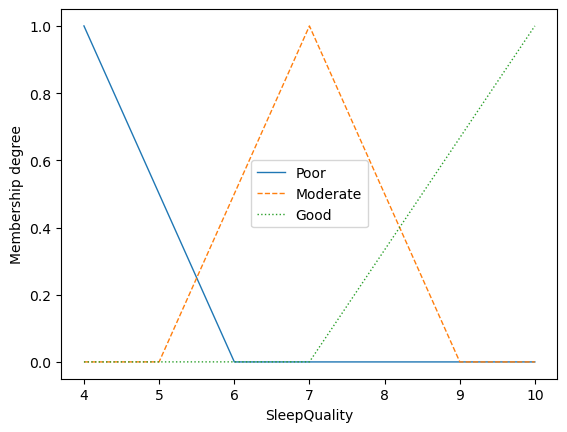

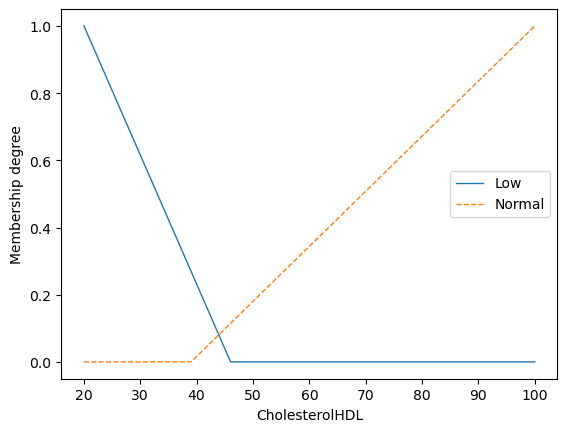

In [406]:
for feature in candidate_features:
    FS.plot_variable(feature)


## Initialise the Rule Base

There are two options for determining the rule base:
- Grid rule base - not ideal for this case since there are 162 possible rules (3x3x3x3x2) which is too large for grid
- Data-driven rule extraction - works well for this case

### Get the linguistic terms for each feature for each sample

In [407]:
def get_max_membership_term(FS, var_name, x):
    """
    For a given crisp value x of feature var_name,
    return the linguistic term with highest membership degree.
    """
    fuzzy_sets = FS.get_fuzzy_sets(var_name)
    best_term = None
    best_mu = -1.0

    for fs in fuzzy_sets:
        term = fs.get_term()
        mu = fs.get_value(x)
        if mu > best_mu:
            best_mu = mu
            best_term = term

    return best_term, best_mu

def compute_max_term_combinations(FS, df, input_vars):
    """
    For each row in df:
      - find the max-membership term for each input variable
      - create a tuple combo of these terms
    Returns:
      df_with_terms: original df with *_term columns and 'combo_key'
    """
    df = df.copy()

    combo_keys = []

    for idx, row in df.iterrows():
        combo_terms = []
        for var in input_vars:
            x = row[var]
            term, mu = get_max_membership_term(FS, var, x)
            df.loc[idx, f"{var}_term"] = term
            combo_terms.append(term)

        combo_key = tuple(combo_terms)
        combo_keys.append(combo_key)

    df["combo_key"] = combo_keys
    return df



### Aggregate diagnoses for term combinations

In [408]:
def aggregate_combinations(df_terms, input_vars, label_col):
    """
    Build a table of:
      - each unique combo_key
      - total count
      - AD / Non-AD counts
      - AD_ratio
    Returns:
      combo_df: data frame with one row per combination
    """
    records = []

    # Group by combo_key
    grouped = df_terms.groupby("combo_key")
    print(len(grouped))

    for combo, group in grouped:
        total = len(group)
        # binary label 0/1 (1 = AD)
        ad_count = group[label_col].sum()
        nonad_count = total - ad_count
        ad_ratio = ad_count / total if total > 0 else 0.0

        # unpack terms into separate columns for readability
        combo_dict = {"combo_key": combo,
                      "total": total,
                      "AD_count": ad_count,
                      "NonAD_count": nonad_count,
                      "AD_ratio": ad_ratio}

        for var, term in zip(input_vars, combo):
            combo_dict[f"{var}_term"] = term

        records.append(combo_dict)

    combo_df = pd.DataFrame.from_records(records)
    return combo_df


### Select Rule Antecedents

The min_support and min_purity are hyperparameters which determine the number of rules. We optimise these with cross validation during HPO.


In [409]:
def select_rule_antecedents(df, input_vars, min_support=45, min_purity=0.8):
    """
    Select combinations that will become rule antecedents, based on:
      - min_support: minimum number of samples for that combination
      - min_purity: majority class proportion

    Returns:
      rules: list of dicts like
             {'antecedent': { 'MMSE': 'Severe', 'Functional Assessment': 'SevereImpairment', ... },
              'total': ...,
              'AD_ratio': ...}
    """
    rules = []

    for _, row in df.iterrows():
        total = row["total"]
        ad_ratio = row["AD_ratio"]

        if total < min_support:
            continue

        # purity: either strongly AD or strongly Non-AD
        if (ad_ratio >= min_purity) or (ad_ratio <= 1 - min_purity):
            antecedent = {}
            for var in input_vars:
                antecedent[var] = row[f"{var}_term"]

            rule_info = {
                "antecedent": antecedent,
                "total": int(total),
                "AD_ratio": float(ad_ratio),
            }
            rules.append(rule_info)

    return rules



### Compute firing strengths for each rule

In [410]:
def get_membership(FS, var_name, term_name, x):
    """
    Return μ_{term_name}(x) for the given variable.
    """
    fuzzy_sets = FS.get_fuzzy_sets(var_name)
    for fs in fuzzy_sets:
        if fs.get_term() == term_name:
            return fs.get_value(x)
    raise ValueError(f"Term '{term_name}' not found for variable '{var_name}'")

def firing_strength_for_rule(FS, rule_antecedent, sample_row):
    """
    Compute the firing strength of one rule for one sample.
    
    rule_antecedent: dict like { 'MMSE': 'Severe', 'Functional Assessment': 'SevereImpairment', ... }
    sample_row: a pandas Series with crisp input values for the same variables
    """
    strength = 1.0   # product t-norm for fuzzy AND

    for var_name, term_name in rule_antecedent.items():
        x = sample_row[var_name]
        mu = get_membership(FS, var_name, term_name, x)
        strength *= mu

        # early exit if strength drops to zero
        if strength == 0.0:
            break

    return strength

def compute_firing_strength_matrix(FS, rules, X):
    """
    FS    : Simpful FuzzySystem with input variables.
    rules : list of rule dicts, each with an 'antecedent' key as above.
    X : DataFrame of raw inputs used for FIS
    
    Returns:
        W: numpy array of shape (N_samples, N_rules)
    """
    N = len(X)
    R = len(rules)
    W = np.zeros((N, R), dtype=float)

    for i, (idx, row) in enumerate(X.iterrows()):
        for j, rule in enumerate(rules):
            antecedent = rule["antecedent"]
            W[i, j] = firing_strength_for_rule(FS, antecedent, row)

    return W

## Training the TS Model

### Fit the TS Consequents

DECISION: We opt for linear consequents (rule describes the region, and the linear model describes the effect of variables in that region) since it allows us to include the effect of the features excluded from the rules

In [411]:
def fit_ts_linear_consequents(W, X, y):
    """
    Learn linear TS consequents:
        y_r(x) = a_{r0} + a_{r1}*x1 + ... + a_{rd}*xd

    using global least squares on the Takagi–Sugeno structure:
        y_hat(x) = sum_r phi_r(x) * y_r(x)

    Parameters
    ----------
    W : array (N, R)
        Firing strengths for each sample and rule.
    X : DataFrame (N, d)
        Raw input features used in the consequents (here: MMSE, Func, ADL).
    y : array-like (N,)
        Binary labels (0/1).

    Returns
    -------
    consequents : list of dicts
        Each dict has keys 'bias' and 'weights'.
    """
    W_ar = np.asarray(W, dtype=float)
    X_ar = np.asarray(X.values, dtype=float)
    y_ar = np.asarray(y, dtype=float)

    N, R = W_ar.shape
    _, d = X_ar.shape

    # Normalise firing strengths -> phi
    sum_w = W_ar.sum(axis=1, keepdims=True) 
    phi = np.zeros_like(W_ar)
    nonzero = sum_w[:, 0] > 0
    phi[nonzero, :] = W_ar[nonzero, :] / sum_w[nonzero, :]

    # Build design matrix Z = (N x (R*(d+1)))
    Z = np.zeros((N, R * (d + 1)), dtype=float)

    for n in range(N):
        for r in range(R):
            coeff = phi[n, r]
            if coeff == 0.0:
                continue
            start = r * (d + 1)
            Z[n, start] = coeff                
            Z[n, start + 1:start + 1 + d] = coeff * X_ar[n, :]

    # Solve least squares: Z @ theta ≈ y
    theta, *_ = np.linalg.lstsq(Z, y_ar, rcond=None)

    # Per-rule parameters
    consequents = []
    for r in range(R):
        start = r * (d + 1)
        a0 = theta[start]
        a = theta[start + 1:start + 1 + d]
        consequents.append({
            "bias": float(a0),
            "weights": a,   
        })

    return consequents



### Predict with the trained TS model

In [412]:
def ts_predict_linear(FS, rules, consequents, X, global_default=0.5):
    """
    Make predictions with a trained linear TS model.

    Parameters
    ----------
    FS : FuzzySystem
        Simpful fuzzy system with defined input variables and sets.
    rules : list of dicts
        Rule antecedents as before.
    consequents : list of dicts
        Output of fit_ts_linear_consequents.
    X : DataFrame
        Raw input features
    global_default : float
        Fallback prediction if a sample has zero firing strength for all rules.

    Returns
    -------
    y_hat : array (N,)
        Continuous outputs
    """
    X_ar = np.asarray(X.values, dtype=float)
    N = len(X)
    R = len(rules)
    d = X_ar.shape[1]

    y_hat = np.zeros(N, dtype=float)

    for i, (idx, row) in enumerate(X.iterrows()):
        # Compute firing strengths for this sample
        w = np.zeros(R, dtype=float)
        for r, rule in enumerate(rules):
            antecedent = rule["antecedent"]
            w[r] = firing_strength_for_rule(FS, antecedent, row)

        sum_w = w.sum()
        if sum_w == 0.0:
            # No rule fires: fallback to global default (e.g. mean of y_train)
            y_hat[i] = global_default
            continue

        # Normalise to phi
        phi = w / sum_w

        # Combine rule outputs
        out = 0.0
        x_i = X_ar[i, :]
        for r in range(R):
            a0 = consequents[r]["bias"]
            a = consequents[r]["weights"]
            y_r = a0 + np.dot(a, x_i)
            out += phi[r] * y_r

        y_hat[i] = out

    return y_hat



### Scoring for Feature selection and HPO

In [413]:
def cv_score_fis(
    FS,
    X,
    y,
    feature_subset,
    min_support,
    min_purity,
    n_rules_max,
    n_splits=5,
    random_state=42,
):
    """
    Compute mean ROC AUC over stratified k-fold CV for one FIS hyperparameter setting.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aucs = []

    # Make sure y is a 1D array / Series
    y = np.asarray(y).ravel()

    for train_idx, val_idx in skf.split(X, y):
        # Split into CV train/val
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]
        y_val = y[val_idx]

        # FIS uses the selected 5 continuous inputs
        X_tr_fis = X_tr[feature_subset].copy()
        X_val_fis = X_val[feature_subset].copy()

        # Build df_tr with diagnosis for rule mining
        df_tr = X_tr_fis.copy()
        df_tr["diagnosis"] = y_tr

        # Max-membership combos per sample (for rule inputs only)
        df_terms_fold = compute_max_term_combinations(FS, df_tr, feature_subset)

        # Aggregate combinations
        combo_df_fold = aggregate_combinations(df_terms_fold, feature_subset, "diagnosis")

        # Select rule antecedents with current min_support / min_purity
        rules_raw = select_rule_antecedents(
            combo_df_fold,
            input_vars=feature_subset,
            min_support=min_support,
            min_purity=min_purity,
        )

        # If no rules survive, this configuration is useless
        if len(rules_raw) == 0:
            # Assign a very poor score
            return 0.5

        # Rank rules by informativeness and keep top n_rules_max
        #    score = support * |AD_ratio - 0.5|
        rules_sorted = sorted(
            rules_raw,
            key=lambda r: r["total"] * abs(r["AD_ratio"] - 0.5),
            reverse=True,
        )
        rules = rules_sorted[:n_rules_max]

        # Compute firing strengths on CV-train
        W_tr = compute_firing_strength_matrix(FS, rules, X_tr_fis)

        # Fit TS linear consequents
        consequents = fit_ts_linear_consequents(W_tr, X_tr_fis, y_tr)

        # Predict scores on CV-val
        global_default = float(y_tr.mean())
        y_val_scores = ts_predict_linear(FS, rules, consequents, X_val_fis,
                                         global_default=global_default)

        # ROC AUC on this fold
        try:
            auc = roc_auc_score(y_val, y_val_scores)
        except ValueError:
            # In case only one class appears in the fold (unlikely with stratified CV)
            auc = 0.5
        aucs.append(auc)

    return float(np.mean(aucs)) if aucs else 0.5

### Feature selection (wrapper)

In [414]:
def evaluate_feature_subset(feature_subset, param_grid, FS, X, y):
    """
    feature_subset: tuple/list of feature names
    param_grid: dict with min_support, min_purity, n_rules_max lists
    FS: your fuzzy system definitions
    X, y: training data (full dataframe, not yet subsetted)
    """
    best_auc = -np.inf
    best_params = None
    print(f"evaluate_feature_subset: {X.columns}")

    # Loop over hyperparameters *for this feature subset*
    for ms in param_grid["min_support"]:
        for mp in param_grid["min_purity"]:
            for nr in param_grid["n_rules_max"]:                
                auc = cv_score_fis(
                    FS=FS,
                    X=X,
                    y=y,
                    feature_subset=list(feature_subset),
                    min_support=ms,
                    min_purity=mp,
                    n_rules_max=nr,
                    n_splits=5,
                    random_state=42,
                )
                # Optional: print for debugging
                print(
                    f"Features={feature_subset}, ms={ms}, mp={mp}, nr={nr} → CV AUC={auc:.3f}"
                )

                if auc > best_auc:
                    best_auc = auc
                    best_params = {
                        "min_support": ms,
                        "min_purity": mp,
                        "n_rules_max": nr,
                    }

    return best_auc, best_params


### Hyperparameter Optimisation and Feature Selection

Of the 5 candidate features, sets of 3, 4 and 5 are evaluated

3 hyperparameters:
- min_support - the minimum number of samples with the same term combination required for rule base
- min_purity - the minimum purity (number of samples with same output value) of a term combination required for rule base
- n_rules_max - maximum number of rules

In [415]:
# Hyperparameter grid (≤ 20 combos)
param_grid = {
    'min_support': [30, 35, 40],
    'min_purity': [0.75, 0.8, 0.85],
    'n_rules_max': [6, 8]
}

param_combos = [
    {"min_support": ms, "min_purity": mp, "n_rules_max": nr}
    for ms, mp, nr in product(
        param_grid["min_support"],
        param_grid["min_purity"],
        param_grid["n_rules_max"],
    )
]

subset_sizes = [3,4,5]
overall_best_auc = -np.inf
overall_best_features = None
overall_best_params = None

for k in subset_sizes:
    for subset in combinations(candidate_features, k):
        print(f"\n=== Evaluating subset {subset} ===")
        auc, best_params = evaluate_feature_subset(
            feature_subset=subset,
            param_grid=param_grid,
            FS=FS,
            X=X_train_cand_inner,
            y=y_train_cand_inner,
        )
        if auc > overall_best_auc:
            overall_best_auc = auc
            overall_best_features = subset
            overall_best_params = best_params

print(f"Best subset: {overall_best_features}")
print(f"Best parameters:{overall_best_params}")
print(f"Mean CV ROC AUC: {overall_best_auc}")



=== Evaluating subset ('MMSE', 'FunctionalAssessment', 'ADL') ===
evaluate_feature_subset: Index(['MMSE', 'FunctionalAssessment', 'ADL', 'SleepQuality',
       'CholesterolHDL'],
      dtype='object')
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.75, nr=6 → CV AUC=0.791
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.75, nr=8 → CV AUC=0.803
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.8, nr=6 → CV AUC=0.797
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.8, nr=8 → CV AUC=0.818
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.85, nr=6 → CV AUC=0.816
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=30, mp=0.85, nr=8 → CV AUC=0.825
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=35, mp=0.75, nr=6 → CV AUC=0.791
27
27
27
27
27
Features=('MMSE', 'FunctionalAssessment', 'ADL'), ms=35, mp=0.75, nr=8 → CV AU

#### Prep Data based on selected features

In [416]:
# Naming conventions:
# fis - best selected parameters
# cand - candidate parameters from feature engineering and clinical rationale
# train_inner - Training set, separate from validation and test
# val - Validation set
# train_full - Training and Validation set together
# test - Test set

fis_features = list(overall_best_features)

X_train_fis_inner = X_train_cand_inner[fis_features].copy()
y_train_fis_inner = y_train_cand_inner.copy()

X_val_fis = X_val_cand[fis_features].copy()
y_val_fis = y_val_cand.copy()

X_train_fis_full = X_train_candidates[fis_features].copy()
y_train_fis_full = y_train_candidates.copy()

X_test_fis = X_test[fis_features].copy()
y_test_fis = y_test.copy()



## Threshold optimisation

DECISION: Use F2 score to optimise threshold since it prioritises recall while balancing with precision

### Train model

Train model with best features and hyperparameters

In [417]:
# FIS training for threshold optimisation using best hyperparameters and features
min_support = overall_best_params["min_support"]
min_purity = overall_best_params["min_purity"]
n_rules_max = overall_best_params["n_rules_max"]

# Build df_terms on train inner
df_train = X_train_fis_inner.copy()
df_train["diagnosis"] = y_train_fis_inner

df_terms = compute_max_term_combinations(FS, df_train, fis_features)
combo_df = aggregate_combinations(df_terms, fis_features, "diagnosis")

# Raw rules from train inner
rules_raw = select_rule_antecedents(
    combo_df,
    input_vars=fis_features,
    min_support=min_support,
    min_purity=min_purity,
)

# Rank and keep top n_rules_max
rules_sorted = sorted(
    rules_raw,
    key=lambda r: r["total"] * abs(r["AD_ratio"] - 0.5),
    reverse=True,
)
rules = rules_sorted[:n_rules_max]

print("Number of final rules:", len(rules))
for r in rules:
    print(r)

# Firing strengths and consequents on train inner
W_train = compute_firing_strength_matrix(FS, rules, X_train_fis_inner)
consequents = fit_ts_linear_consequents(W_train, X_train_fis_inner, y_train_fis_inner)

global_default = float(np.mean(y_train_fis_inner))

27
Number of final rules: 8
{'antecedent': {'MMSE': 'Severe', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'VeryDependent'}, 'total': 130, 'AD_ratio': 0.9692307692307692}
{'antecedent': {'MMSE': 'Severe', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 120, 'AD_ratio': 0.1}
{'antecedent': {'MMSE': 'Mild', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 65, 'AD_ratio': 0.1076923076923077}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'VeryDependent'}, 'total': 47, 'AD_ratio': 0.02127659574468085}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 45, 'AD_ratio': 0.06666666666666667}
{'antecedent': {'MMSE': 'Mild', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'VeryDependent'}, 'total': 32, 'AD_ratio': 1.0}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'Independent'}, 'total': 38, 'AD_ratio': 0.07894736

### Run Threshold optimisation

In [418]:
y_val_scores = ts_predict_linear(
    FS, rules, consequents, X_val_fis, global_default=global_default
)

threshold_grid = np.linspace(0.0, 1.0, 101)

best_thresh = 0.5
best_f2 = -1.0
best_acc = -1.0

for thr in threshold_grid:
    y_val_pred = (y_val_scores >= thr).astype(int)

    f2 = fbeta_score(y_val_fis, y_val_pred, beta=2)
    acc = accuracy_score(y_val_fis, y_val_pred)

    if f2 > best_f2:
        best_f2 = f2
        best_acc = acc
        best_thresh = thr

print(f"Best threshold on validation set (F2): {best_thresh:.3f}")
print(f"Validation F2 at best threshold: {best_f2:.3f}")
print(f"Validation accuracy at best threshold: {best_acc:.3f}")


Best threshold on validation set (F2): 0.260
Validation F2 at best threshold: 0.804
Validation accuracy at best threshold: 0.656


## Evaluation on Test Set

### Train Model

Train the model on full train set

In [419]:
# Final FIS training on full training set using best hyperparameters and features
# Build df_terms on full train
df_train_full = X_train_fis_full.copy()
df_train_full["diagnosis"] = y_train_fis_full

df_terms_full = compute_max_term_combinations(FS, df_train_full, fis_features)
combo_df_full = aggregate_combinations(df_terms_full, fis_features, "diagnosis")

# Raw rules from full train
rules_raw_full = select_rule_antecedents(
    combo_df_full,
    input_vars=fis_features,
    min_support=min_support,
    min_purity=min_purity,
)

# Rank and keep top n_rules_max
rules_sorted_full = sorted(
    rules_raw_full,
    key=lambda r: r["total"] * abs(r["AD_ratio"] - 0.5),
    reverse=True,
)
rules_final = rules_sorted_full[:n_rules_max]

print("Number of final rules:", len(rules_final))
for r in rules_final:
    print(r)

# Firing strengths and consequents on full train
W_train_final = compute_firing_strength_matrix(FS, rules_final, X_train_fis_full)
consequents_final = fit_ts_linear_consequents(W_train_final, X_train_fis_full, y_train_fis_full)

# Evaluate on TRAIN (just to see)
global_default_final = float(np.mean(y_train_fis_full))
y_train_score = ts_predict_linear(
    FS, rules_final, consequents_final, X_train_fis_full, global_default=global_default_final
)
train_auc = roc_auc_score(y_train_fis_full, y_train_score)
print("Final FIS TRAIN ROC AUC:", train_auc)




27
Number of final rules: 8
{'antecedent': {'MMSE': 'Severe', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'VeryDependent'}, 'total': 157, 'AD_ratio': 0.9617834394904459}
{'antecedent': {'MMSE': 'Severe', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 143, 'AD_ratio': 0.0979020979020979}
{'antecedent': {'MMSE': 'Mild', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 77, 'AD_ratio': 0.1038961038961039}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'VeryDependent'}, 'total': 56, 'AD_ratio': 0.017857142857142856}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'NoImpairment', 'ADL': 'Independent'}, 'total': 56, 'AD_ratio': 0.05357142857142857}
{'antecedent': {'MMSE': 'Mild', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'VeryDependent'}, 'total': 45, 'AD_ratio': 1.0}
{'antecedent': {'MMSE': 'Normal', 'FunctionalAssessment': 'SevereImpairment', 'ADL': 'Independent'}, 'total': 46, 'AD_ra

### Evaluate

In [420]:
# Test evaluation
print(f"FINAL MODEL:\nFeatures: {fis_features}\nHyperparameters: {overall_best_params}\nThreshold: {best_thresh}")

y_test_score = ts_predict_linear(
    FS, rules_final, consequents_final, X_test_fis, global_default=global_default_final
)
test_auc = roc_auc_score(y_test_fis, y_test_score)
print("Final FIS TEST ROC AUC:", test_auc)

# Apply the optimised threshold from the validation set
y_test_pred = (y_test_score >= best_thresh).astype(int)

print(f"\nTest metrics at threshold = {best_thresh:.3f}")
print("Confusion matrix:")
print(confusion_matrix(y_test_fis, y_test_pred))

print("\nClassification report:")
print(classification_report(y_test_fis, y_test_pred, digits=3))

test_f2 = fbeta_score(y_test_fis, y_test_pred, beta=2)
print(f"Test F2 at threshold = {best_thresh:.3f}: {test_f2:.3f}")



FINAL MODEL:
Features: ['MMSE', 'FunctionalAssessment', 'ADL']
Hyperparameters: {'min_support': 30, 'min_purity': 0.85, 'n_rules_max': 8}
Threshold: 0.26
Final FIS TEST ROC AUC: 0.8935062476334722

Test metrics at threshold = 0.260
Confusion matrix:
[[77 62]
 [ 4 72]]

Classification report:
              precision    recall  f1-score   support

           0      0.951     0.554     0.700       139
           1      0.537     0.947     0.686        76

    accuracy                          0.693       215
   macro avg      0.744     0.751     0.693       215
weighted avg      0.805     0.693     0.695       215

Test F2 at threshold = 0.260: 0.822
